In [1]:
import os
import sys
import yaml
sys.path.append(os.path.abspath('.')) # to run files that are away
os.environ["WANDB_SILENT"] = "true"  # Suppress WandB logs

libraries = ["torch", "numpy", "polars"]
modules   = {lib: sys.modules.get(lib) for lib in libraries}

if not modules["torch"]:
    import torch
if not modules["numpy"]:
    import numpy as np
if not modules["polars"]:
    import polars as pl

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

from utils import compute_reconstruction_loss



/home/fouadabiad/miniconda3/envs/silofuse_env/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
"""Loading the data"""

with open('params.yaml', 'r') as file:
    yaml_config = yaml.safe_load(file)

data_file  = f"./datasets/{yaml_config['dataset']['filename']}"
df         = pd.read_csv(data_file)

X_scaled   = MinMaxScaler().fit_transform(df.values)
print(X_scaled.shape)
X_tensor   = torch.tensor(X_scaled, dtype=torch.float32)
# X_tensor_reshaped = X_tensor.transpose(0, 1)
# dataset    = TensorDataset(X_tensor_reshaped, X_tensor_reshaped)
dataset    = TensorDataset(X_tensor, X_tensor)  # Autoencoder reconstructs the input

num_time_series = len(dataset)
# train_size = int(yaml_config['dataset']['train_valid_split'] * len(df))
train_size = int(yaml_config['dataset']['train_valid_split'] * num_time_series)
# valid_size = len(df) - train_size
valid_size = num_time_series - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])


(19735, 28)


In [3]:
"""Autoencoder training"""

import autoencoder as ae

hidden_dim        = yaml_config['autoencoder_design']['hidden_dim']
encoding_dim      = yaml_config['autoencoder_design']['encoding_dim']
latent_dim        = yaml_config['autoencoder_design']['latent_dim']
dropout_prob      = yaml_config['autoencoder_design']['dropout_prob']
training_epochs   = yaml_config['autoencoder_training']['training_epochs']
batch_size        = yaml_config['autoencoder_training']['batch_size']
optimizer_lr      = yaml_config['autoencoder_training']['optimizer_lr']
weight_decay      = yaml_config['autoencoder_training']['weight_decay']
training_patience = yaml_config['autoencoder_training']['training_patience']
scheduler_patience= yaml_config['autoencoder_training']['scheduler_patience']
scheduler_mode    = yaml_config['autoencoder_training']['scheduler_mode']
scheduler_factor  = yaml_config['autoencoder_training']['scheduler_factor']

device = ae.device
print(f"Using device from module: {device}")

# Create DataLoader objects for train and validation datasets
input_size   = X_scaled.shape[1]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

autoencoder  = ae.Autoencoder(input_size, hidden_dim, encoding_dim, latent_dim, dropout_prob)
optimizer    = torch.optim.AdamW(autoencoder.parameters(), lr=optimizer_lr, weight_decay=weight_decay)
scheduler    = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, scheduler_mode, patience=scheduler_patience, factor=scheduler_factor)

ae.train_autoencoder(device, autoencoder, training_epochs, train_loader, optimizer, scheduler,
                     validation_loader=val_loader, patience = training_patience)


Using device: cuda
Using device from module: cuda
Epoch [1/30], training loss: 0.1166
Validation loss: 0.0217
Epoch [2/30], training loss: 0.0408
Validation loss: 0.0069
Epoch [3/30], training loss: 0.0211
Validation loss: 0.0030
Epoch [4/30], training loss: 0.0129
Validation loss: 0.0015
Epoch [5/30], training loss: 0.0085
Validation loss: 0.0009
Epoch [6/30], training loss: 0.0057
Validation loss: 0.0006
Epoch [7/30], training loss: 0.0040
Validation loss: 0.0004
Epoch [8/30], training loss: 0.0026
Validation loss: 0.0002
Epoch [9/30], training loss: 0.0018
Validation loss: 0.0001
Epoch [10/30], training loss: 0.0012
Validation loss: 0.0001
Epoch [11/30], training loss: 0.0008
Validation loss: 0.0001
Epoch [12/30], training loss: 0.0005
Validation loss: 0.0000
Epoch [13/30], training loss: 0.0003
Validation loss: 0.0000
Epoch [14/30], training loss: 0.0002
Validation loss: 0.0000
Epoch [15/30], training loss: 0.0001
Validation loss: 0.0000
Epoch [16/30], training loss: 0.0001
Validat

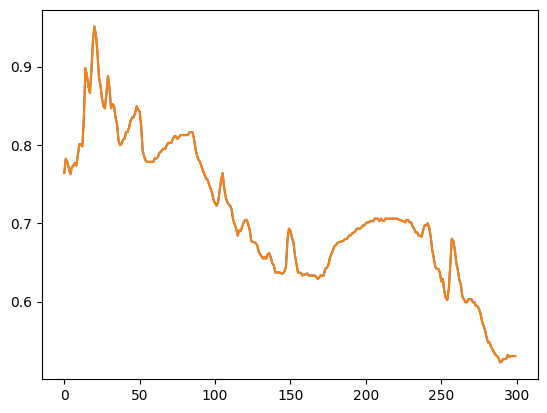

In [4]:
"""Run AE on dataset for reconstruction, anomaly detection, feature extraction, classification"""

autoencoder.eval()
autoencoder.to(device)

with torch.no_grad():
    X_input = X_tensor.to(device)
    X_reconstructed = autoencoder(X_input).cpu().numpy()

variate_to_plot = 9
plt.plot(X_scaled[:300, variate_to_plot])
plt.plot(X_reconstructed[:300, variate_to_plot])


In [5]:
"""Evaluate AE reconstruction"""

# from utils import evaluate_and_plot_autoencoder_metrics

# should_we_plot = 1
# ks_stats, wasserstein_dists, real_acfs, generated_acfs, dtw_distances = evaluate_and_plot_autoencoder_metrics(X_scaled, X_reconstructed, should_we_plot)



'Evaluate AE reconstruction'

In [ ]:
"""Diffusion training"""

import diffusion_model as diff
from diffusion_model import Diffusion
from torch.utils.data import Dataset, DataLoader

diff_steps        = yaml_config['diffusion_design']['diff_steps']
cos_start_offset  = yaml_config['noise_scheduler']['cos_start_offset']
noise_profile     = yaml_config['noise_scheduler']['noise_profile']
start_noise_val   = yaml_config['noise_scheduler']['start_noise_val']
end_noise_val     = yaml_config['noise_scheduler']['end_noise_val']
train_epochs      = yaml_config['diffusion_training']['train_epochs']
training_patience = yaml_config['diffusion_training']['training_patience']
optimizer_lr      = yaml_config['diffusion_training']['optimizer_lr']
weight_decay      = yaml_config['diffusion_training']['weight_decay']
scheduler_patience= yaml_config['diffusion_training']['scheduler_patience']
scheduler_mode    = yaml_config['diffusion_training']['scheduler_mode']
scheduler_factor  = yaml_config['diffusion_training']['scheduler_factor']
dropout_prob      = yaml_config['Unet_design']['dropout_prob']
base_channels     = yaml_config['Unet_design']['base_channels']
embedding_dim     = yaml_config['Unet_design']['embedding_dim']

device = diff.device
print(f"Using device from module: {device}")

sequence_length = 1231 #what is this?

class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.sequence_length = sequence_length
        self.num_sequences = len(data) - sequence_length

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        start_idx = idx
        end_idx = start_idx + self.sequence_length
        segment = self.data[start_idx:end_idx].T  # Shape: (features, sequence_length)
        return segment

train_dataset_diffusion = TimeSeriesDataset(X_scaled[:train_size], sequence_length)
train_loader_diffusion  = DataLoader(train_dataset_diffusion, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset_diffusion = TimeSeriesDataset(X_scaled[train_size:], sequence_length)
val_loader_diffusion  = DataLoader(val_dataset_diffusion, batch_size=batch_size, shuffle=False, drop_last=True)

betas = Diffusion.get_noise_schedule(start_val=start_noise_val, end_val=end_noise_val, diff_steps=diff_steps,
                                cos_start_offset=cos_start_offset, noise_profile=noise_profile)
# diffusion_model = diff.UNet(X_scaled.shape[1], dropout_prob, base_channels) # in_channels = num_features
# diffusion_model = diff.UNet(X_scaled.shape[1], dropout_prob, embedding_dim=128) # Explicitly set embedding_dim
diffusion_model = diff.UNet(X_scaled.shape[1], dropout_prob, embedding_dim=embedding_dim, base_channels=base_channels)

optimizer       = torch.optim.AdamW(diffusion_model.parameters(), lr=optimizer_lr, weight_decay=weight_decay)
scheduler       = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_epochs)

diff.train_diffusion(device, diffusion_model, train_loader_diffusion, optimizer, scheduler, betas,
                     diff_steps, train_epochs, val_loader_diffusion, training_patience)


Using device: cuda
Using device from module: cuda
conv_block: in_channels = 28, out_channels = 64
conv_block: in_channels = 64, out_channels = 128
conv_block: in_channels = 128, out_channels = 256
conv_block: in_channels = 256, out_channels = 256
conv_block: in_channels = 256, out_channels = 128
conv_block: in_channels = 128, out_channels = 64
Epoch [1/100], loss: 0.8318, Validation loss: 0.7563
Epoch [2/100], loss: 0.7573, Validation loss: 0.7293
Epoch [3/100], loss: 0.7393, Validation loss: 0.7283
Epoch [4/100], loss: 0.7293, Validation loss: 0.7188
Epoch [5/100], loss: 0.7198, Validation loss: 0.6993
Epoch [6/100], loss: 0.7134, Validation loss: 0.7069
Epoch [7/100], loss: 0.7111, Validation loss: 0.6997
Epoch [8/100], loss: 0.7113, Validation loss: 0.7059
Epoch [9/100], loss: 0.7099, Validation loss: 0.6939
Epoch [10/100], loss: 0.7081, Validation loss: 0.6920
Epoch [11/100], loss: 0.7093, Validation loss: 0.6875
Epoch [12/100], loss: 0.7066, Validation loss: 0.6832
Epoch [13/100],

In [7]:
"""Generate new samples from diffusion"""

diffusion_model.eval()
diffusion_model.to(device)

with torch.no_grad():
    sample_shape      = (1, X_scaled.shape[1], 128)
    generated_samples = diff.sample_new_data(diffusion_model, betas, diff_steps, sample_shape)
    print(f"Generated samples shape: {generated_samples.shape}")

    generated_array = generated_samples.cpu().squeeze(0).numpy() # Move to CPU then convert to NumPy
    num_features    = generated_array.shape[0]
    time_steps      = generated_array.shape[1]

generated_samples.shape

/home/fouadabiad/projects/silofuse_timeseries/diffusion_model.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  betas      = torch.tensor(betas, device=x_t.device)


Generated samples shape: torch.Size([1, 28, 128])


torch.Size([1, 28, 128])

In [8]:
"""Making LDM"""

# Silofuse
num_clients = 3
clients_data= [X_scaled[:,1], X_scaled[:,2], X_scaled[:,3]]

latents = []
for data in clients_data:
    latent = ae.Autoencoder.encode_to_latent
    latents.append(latent)

synth_latents = diffusion_model.forward(latents)
synth_client_latents = split(synth_latents)

for latent_data in synth_latents:
    synth_data = ae.Autoencoder.decode_from_latent(latent_data)



TypeError: UNet.forward() missing 1 required positional argument: 't'